# **Twitter Sentiment Analysis Group Project**

## **Business Understanding**

### **Overview**

This project aims to build NLP models that can predict the sentiment of tweets for Apple and Google products as either positive, negative or neutral.

The NLP base model will be a binary classifier focusing on the positive and negative reviews and will expand into a multiclass classifier capturing neutral sentiment reviews.

This will aid the companies in collection of reviews for their products and build or improve said products from the reviews.

### **Business Problem and Stakeholders**


Marketing and Branding teams at technology companies such as Apple and Google rely heavily on public feedback to shape brand strategies. Social media platforms such as twitter provide a large source of customer feedback that is difficult to analyze manually due to the nature of tweets(text). The business problem for this project is the need for a system that can accurately classify the sentiment of tweets towards the products as positive, negative or neutral.  
By automatically identifying changes in public sentiments, marketing brands and teams can track brand perception and respond more quickly to customer feedback. The model will support data-driven branding decisions by transforming raw tweets into actionable sentiment insights.


### **Objectives**
#### **Main Objective**
Build a model that can rate the sentiment of a Tweet based on its content.
#### **Specific Objectives**
1. 

## **Data Understanding**
The dataset being used is a set of tweets about Apple and Google products evaluated by some contributors. The crowd was asked if the tweet expressed positive, negative, or no emotion towards the brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion.  
This dataset contains 9093 data rows of tweets. It contains the tweets, the product/company and the sentiments.

In [1]:
# Import required libraries

# Data loading and manipulation
import pandas as pd
import numpy as np

# Text preprocessing and NLP
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk import FreqDist



# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
from wordcloud import WordCloud
#from PIL import Image, ImageDraw, ImageFont

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


# Model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


# Model interpretation and saving
import lime
import lime.lime_text
import joblib
import pickle

#webscrapping
import tweepy
import time

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set(style="whitegrid")
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})


In [2]:
#loading the data and renaming columns
df = pd.read_csv('./Data/judge-1377884607_tweet_product_company.csv',
    encoding='latin-1')
df.columns = ['tweet_text', 'product/company', 'sentiment']
df.head()

,tweet_text,product/company,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_text       9092 non-null   object
 1   product/company  3291 non-null   object
 2   sentiment        9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


There are missing values in our data. The dataset has 9093 entries and 3 columns. All columns are string data types.

In [4]:
df.shape

(9093, 3)

In [5]:
df['sentiment'] .value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [6]:
df['product/company'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product/company, dtype: int64

In [7]:
df.describe()

,tweet_text,product/company,sentiment
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


## **Data Cleaning and Preprocessing**

### **Data Cleaning**

In [8]:
clean_df = df.copy()

In [9]:
clean_df.duplicated().sum()

22

In [10]:
clean_df = clean_df.drop_duplicates()
clean_df.duplicated().sum()

0

In [11]:
clean_df.isnull().sum()

tweet_text            1
product/company    5789
sentiment             0
dtype: int64

In [12]:
clean_df = clean_df.dropna(subset=['tweet_text'])

In [13]:
clean_df = clean_df[['tweet_text', 'sentiment']]

In [14]:
clean_df.isnull().sum()

tweet_text    0
sentiment     0
dtype: int64

In [15]:
clean_df['sentiment'].value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: sentiment, dtype: int64

In [16]:
# Map sentiment labels
clean_df['sentiment'] = clean_df['sentiment'].map({
    'Positive emotion': 'positive',
    'Negative emotion': 'negative',
    'No emotion toward brand or product': 'neutral',
    "I can't tell": 'uncertain'
})

In [17]:
clean_df = clean_df[clean_df['sentiment'] != "uncertain"].reset_index(drop=True)

In [18]:
clean_df['sentiment'].value_counts()

neutral     5375
positive    2970
negative     569
Name: sentiment, dtype: int64

In [19]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914 entries, 0 to 8913
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  8914 non-null   object
 1   sentiment   8914 non-null   object
dtypes: object(2)
memory usage: 139.4+ KB


In [20]:
# Text cleaning
def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) # Remove URLs
    text = re.sub(r'@\w+','', text) # Remove mentions
    text = re.sub(r'#\w+', '', text) # Remove hashtags 
    text = re.sub(r'[^A-Za-z\s]', '', text) # Remove special characters and numbers(Punctuations, emojis...)
    return text

clean_df['clean_text'] = clean_df['tweet_text'].apply(clean_text)
clean_df.head()


,tweet_text,sentiment,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative,i have a g iphone after hrs tweeting at it ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive,know about awesome ipadiphone app that youl...
2,@swonderlin Can not wait for #iPad 2 also. The...,positive,can not wait for also they should sale them...
3,@sxsw I hope this year's festival isn't as cra...,negative,i hope this years festival isnt as crashy as ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,positive,great stuff on fri marissa mayer google tim ...


### **Data Preprocessing**

In [21]:
basic_token_pattern = r"[a-zA-Z]+(?:'[a-z]+)?"
tokenizer = RegexpTokenizer(basic_token_pattern)
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()


In [22]:
prepocessed_tweets = []
for tweet in clean_df['clean_text']:
    tokens = tokenizer.tokenize(tweet)
    stopped_tokens = [word for word in tokens if word not in stopwords_list]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stopped_tokens]
    prepocessed_tweets.append(' '.join(lemmatized_tokens))
clean_df['preprocessed_tweet'] = prepocessed_tweets
clean_df.head()


,tweet_text,sentiment,clean_text,preprocessed_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative,i have a g iphone after hrs tweeting at it ...,g iphone hr tweeting dead need upgrade plugin ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive,know about awesome ipadiphone app that youl...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,positive,can not wait for also they should sale them...,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,negative,i hope this years festival isnt as crashy as ...,hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,positive,great stuff on fri marissa mayer google tim ...,great stuff fri marissa mayer google tim oreil...


## **Exploratory Data Analysis**

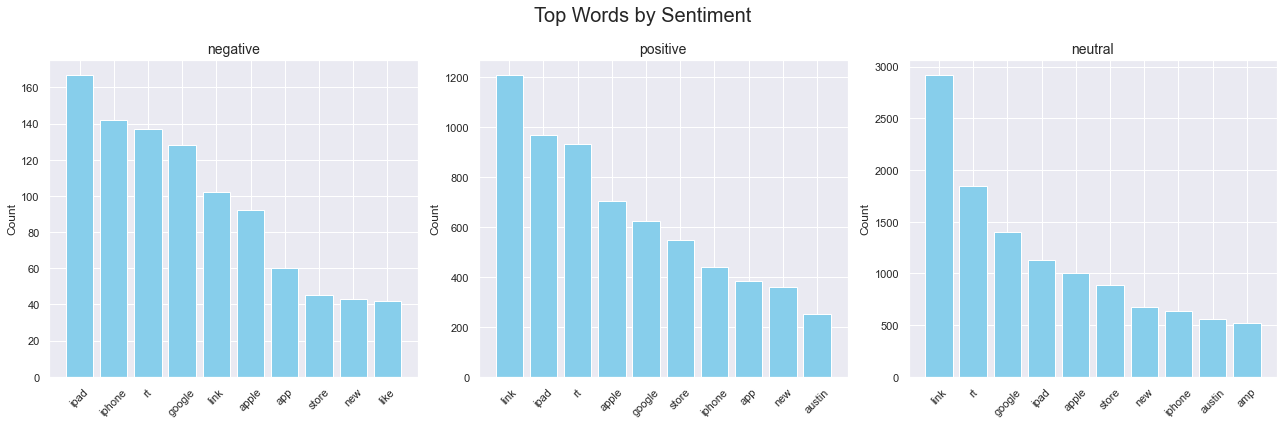

In [23]:
# Ensure each tweet is a list of words
clean_df['tokens'] = clean_df['preprocessed_tweet'].apply(lambda x: x.split())

# Get the unique sentiment labels
sentiment_labels = clean_df['sentiment'].unique()

# Create 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18,6))
fig.set_tight_layout(True)

# Plot top 10 words for each sentiment
for idx, sentiment in enumerate(sentiment_labels):
    # Combine all words for this sentiment
    all_words = [word for tokens in clean_df[clean_df['sentiment'] == sentiment]['tokens'] for word in tokens]
    freq_dist = FreqDist(all_words)
    top_words = freq_dist.most_common(10)
    
    # Unpack for plotting
    words, counts = zip(*top_words)
    
    axes[idx].bar(words, counts, color='skyblue')
    axes[idx].set_title(sentiment, fontsize=14)
    axes[idx].set_ylabel("Count")
    axes[idx].tick_params(axis="x", rotation=45)

fig.suptitle("Top Words by Sentiment", fontsize=20)
plt.show()


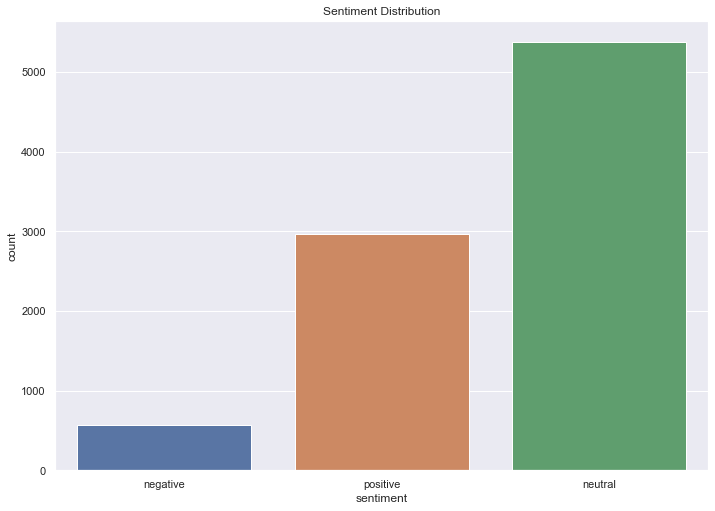

In [24]:
sns.countplot(x='sentiment', data=clean_df)
plt.title("Sentiment Distribution")
plt.show()

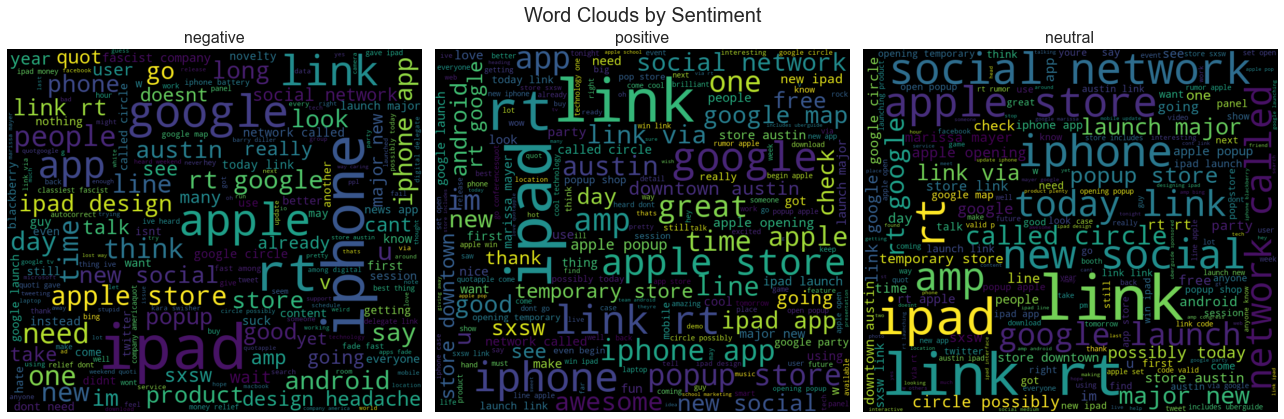

In [25]:
# Create 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18,6))
fig.set_tight_layout(True)

# Generate WordCloud for each sentiment
for idx, sentiment in enumerate(sentiment_labels):
    # Combine all words into a single string
    all_words = ' '.join(
        word for tokens in clean_df[clean_df['sentiment'] == sentiment]['tokens'] for word in tokens
    )
    
    # Create WordCloud
    wordcloud = WordCloud(width=800,height=700,max_font_size=120).generate(all_words)
    
    # Plot in the corresponding subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(sentiment, fontsize=16)

fig.suptitle("Word Clouds by Sentiment", fontsize=20)
plt.show()
